# Load Required Packages

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from interpret.glassbox import ExplainableBoostingClassifier

import plotly.express as px
import plotly.graph_objects as go
# import plotly.io as pio 
from IPython.display import Image, display
# from IPython.display import display, Markdown

from gains import gains

import session_info

# Import and Prep Data

In [2]:
X, y = fetch_openml('telco-customer-churn', version=1, as_frame=True, return_X_y=True, parser='auto')

total_df = pd.concat([pd.DataFrame(y), X], axis=1)

del(X, y)

total_df = total_df.rename(columns={'gender': 'Gender',
                                    'SeniorCitizen': 'Senior Citizen',
                                    'tenure': 'Tenure',
                                    'PhoneService': 'Phone Service',
                                    'MultipleLines': 'Multiple Lines',
                                    'InternetService': 'Internet Service',
                                    'OnlineSecurity': 'Online Security',
                                    'OnlineBackup': 'Online Backup',
                                    'DeviceProtection': 'Device Protection',
                                    'TechSupport': 'Tech Support',
                                    'StreamingTV': 'Streaming TV',
                                    'StreamingMovies': 'Streaming Movies',
                                    'PaperlessBilling': 'Paperless Billing',
                                    'PaymentMethod': 'Payment Method',
                                    'MonthlyCharges': 'Monthly Charges',
                                    'TotalCharges': 'Total Charges'})

total_df['Senior Citizen'] = np.where(total_df['Senior Citizen'] == 1, 'Yes', 'No')
total_df['Total Charges'] = pd.to_numeric(total_df['Total Charges'], errors='coerce')
total_df['Tenure'] = total_df['Tenure'].astype('int64')

total_df.head()

,Churn,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,No,Female,No,Yes,No,1,No,'No phone service',DSL,No,Yes,No,No,No,No,Month-to-month,Yes,'Electronic check',29.85,29.85
1,No,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,'One year',No,'Mailed check',56.95,1889.50
2,Yes,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,'Mailed check',53.85,108.15
3,No,Male,No,No,No,45,No,'No phone service',DSL,Yes,No,Yes,Yes,No,No,'One year',No,'Bank transfer (automatic)',42.30,1840.75
4,Yes,Female,No,No,No,2,Yes,No,'Fiber optic',No,No,No,No,No,No,Month-to-month,Yes,'Electronic check',70.70,151.65


In [3]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Churn              7043 non-null   object 
 1   Gender             7043 non-null   object 
 2   Senior Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure             7043 non-null   int64  
 6   Phone Service      7043 non-null   object 
 7   Multiple Lines     7043 non-null   object 
 8   Internet Service   7043 non-null   object 
 9   Online Security    7043 non-null   object 
 10  Online Backup      7043 non-null   object 
 11  Device Protection  7043 non-null   object 
 12  Tech Support       7043 non-null   object 
 13  Streaming TV       7043 non-null   object 
 14  Streaming Movies   7043 non-null   object 
 15  Contract           7043 non-null   object 
 16  Paperless Billing  7043 

In [4]:
# Investiate the 11 records with missing values for  `Total Charges`

total_df['Binary Total Charges'] = np.where(total_df['Total Charges'].isna(), 'Missing', 'Not Missing')

total_df['Binary Tenure'] = total_df['Tenure'].apply(lambda x: '1+' if x > 0 else ('0' if x == 0 else '<0'))

total_df[['Binary Total Charges', 'Binary Tenure', 'Churn']].value_counts()

Binary Total Charges  Binary Tenure  Churn
Not Missing           1+             No       5163
                                     Yes      1869
Missing               0              No         11
Name: count, dtype: int64

In [5]:
# Discard records with missing `Total Charges`
total_df = total_df[~total_df['Total Charges'].isnull()].reset_index(drop=True)
total_df.drop(columns=['Binary Total Charges', 'Binary Tenure'], inplace=True)

# Create a unique identifier for each row
total_df['CustomerID'] = total_df.index + 1
total_df = total_df[ [ 'CustomerID'] + [col for col in total_df.columns if col != 'CustomerID']]

total_df.head()

,CustomerID,Churn,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,...,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,1,No,Female,No,Yes,No,1,No,'No phone service',DSL,...,Yes,No,No,No,No,Month-to-month,Yes,'Electronic check',29.85,29.85
1,2,No,Male,No,No,No,34,Yes,No,DSL,...,No,Yes,No,No,No,'One year',No,'Mailed check',56.95,1889.50
2,3,Yes,Male,No,No,No,2,Yes,No,DSL,...,Yes,No,No,No,No,Month-to-month,Yes,'Mailed check',53.85,108.15
3,4,No,Male,No,No,No,45,No,'No phone service',DSL,...,No,Yes,Yes,No,No,'One year',No,'Bank transfer (automatic)',42.30,1840.75
4,5,Yes,Female,No,No,No,2,Yes,No,'Fiber optic',...,No,No,No,No,No,Month-to-month,Yes,'Electronic check',70.70,151.65


In [6]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7032 non-null   int64  
 1   Churn              7032 non-null   object 
 2   Gender             7032 non-null   object 
 3   Senior Citizen     7032 non-null   object 
 4   Partner            7032 non-null   object 
 5   Dependents         7032 non-null   object 
 6   Tenure             7032 non-null   int64  
 7   Phone Service      7032 non-null   object 
 8   Multiple Lines     7032 non-null   object 
 9   Internet Service   7032 non-null   object 
 10  Online Security    7032 non-null   object 
 11  Online Backup      7032 non-null   object 
 12  Device Protection  7032 non-null   object 
 13  Tech Support       7032 non-null   object 
 14  Streaming TV       7032 non-null   object 
 15  Streaming Movies   7032 non-null   object 
 16  Contract           7032 

# Train/Test Split

In [7]:
# Using stratified random sampling

train_df, test_df = train_test_split(total_df, train_size=0.75, stratify=total_df['Churn'], random_state=22)

print("Train Sample:   # Rows = {:,}  Churn Rate = {:.1f}%".format(train_df.shape[0], (train_df['Churn']=='Yes').mean()*100))
print(" Test Sample:   # Rows = {:,}  Churn Rate = {:.1f}%".format(test_df.shape[0], (test_df['Churn']=='Yes').mean()*100))

Train Sample:   # Rows = 5,274  Churn Rate = 26.6%
 Test Sample:   # Rows = 1,758  Churn Rate = 26.6%


# Fit Models

In [8]:
features = [col for col in total_df.columns if col not in ['CustomerID', 'Churn']]

print(f"Number of Features: {len(features)}")
print(f"\nFeature Names: {features}")

Number of Features: 19

Feature Names: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges']


In [9]:
y_train = train_df['Churn']
X_train = train_df[features]

y_test = test_df['Churn']
X_test = test_df[features]

## scikit-learn

In [10]:
categorical_features = list(total_df[features].select_dtypes(include='object').columns)

numeric_features = list(total_df[features].select_dtypes(include=['float64', 'int64']).columns)


print(f"Categorical Features: {categorical_features}")
print(f"\nNumeric Features: {numeric_features}")

Categorical Features: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']

Numeric Features: ['Tenure', 'Monthly Charges', 'Total Charges']


In [11]:
categorical_encoder = OneHotEncoder(handle_unknown='ignore')

numeric_y_train = y_train.map({'Yes': 1, 'No': 0})
numeric_y_test = y_test.map({'Yes': 1, 'No': 0})

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_features),
        ("scale", StandardScaler(), numeric_features)
    ]
)

lr_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", LogisticRegression(random_state=3006))
    ]
)

rf_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=3006))
    ]
)

lr_model = lr_pipeline.fit(X_train, numeric_y_train)
rf_model = rf_pipeline.fit(X_train, numeric_y_train)

## Explainable Boosting Machine (EBM)

In [12]:
ebm_model = ExplainableBoostingClassifier(interactions=0, random_state=3006)

ebm_model.fit(X_train, y_train);

# Evaluate Models

In [13]:
lr_test_df = pd.DataFrame({'Model': 'Logistic Regression',
                           'Truth': y_test,
                           'Score': lr_model.predict_proba(X_test)[:,1]})

rf_test_df = pd.DataFrame({'Model': 'Random Forest',
                           'Truth': y_test,
                           'Score': rf_model.predict_proba(X_test)[:,1]})

ebm_test_df = pd.DataFrame({'Model': 'EBM',
                            'Truth': y_test,
                            'Score': ebm_model.predict_proba(X_test)[:,1]})

test_scores_df = pd.concat([lr_test_df, rf_test_df, ebm_test_df], ignore_index=True)

test_scores_df

,Model,Truth,Score
0,Logistic Regression,Yes,0.526548
1,Logistic Regression,No,0.080807
2,Logistic Regression,No,0.025288
3,Logistic Regression,No,0.070488
4,Logistic Regression,No,0.075447
...,...,...,...
5269,EBM,No,0.043266
5270,EBM,Yes,0.243416
5271,EBM,Yes,0.690454
5272,EBM,No,0.164065


In [14]:
gain_stats_by_model, gains_by_model_df = gains(input_df=test_scores_df,
                                               series_var='Model',
                                               truth_var='Truth',
                                               score_var='Score') 

gain_stats_by_model.rename(columns={'Series': 'Model'}, inplace=True)

gain_stats_by_model.sort_values(by='Gain Capture', ascending=False, inplace=True)

gains_by_model_df = pd.merge(gain_stats_by_model, gains_by_model_df, how='left', on='Model')

gain_stats_by_model.style.hide(axis='index')

Model,Gain Capture
EBM,0.694896
Logistic Regression,0.693855
Random Forest,0.637119


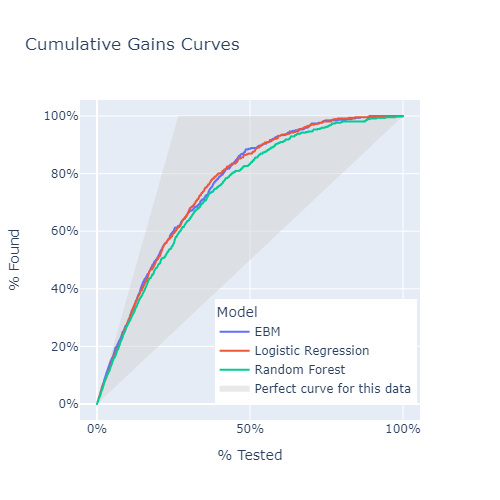

In [15]:
fig = px.line(gains_by_model_df, x='CumPct_Sample', y='CumPct_Target', color='Model',
              title='Cumulative Gains Curves',
              labels={'CumPct_Sample': '% Tested', 'CumPct_Target': '% Found'},
              width=500, height=500)

fig.add_trace(
    go.Scatter(x=[0, (y_test=='Yes').mean(), 1, 0],
               y=[0, 1, 1, 0],
               mode='text',
               fill='toself',
               fillcolor='lightgrey',
               opacity=0.5,
               name='Perfect curve for this data')
)

fig.layout.xaxis.tickformat = ',.0%'
fig.layout.yaxis.tickformat = ',.0%'

fig.update_layout(
    legend=dict(
        yanchor='bottom', y=0.05, xanchor='right', x=0.99
    ),
    hovermode=False
)

# To display in JupyterLab
# fig.show()

# To display in GitHub and JupyterLab
display(Image(fig.to_image(format='png')))

# Review of Champion Model

## Performance by Decile

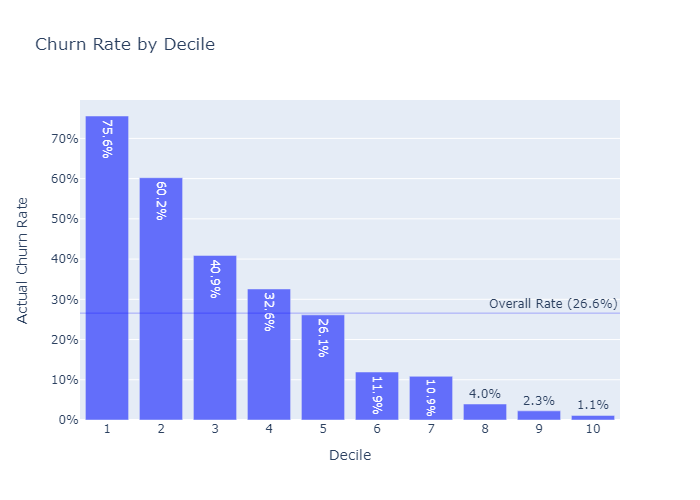

In [16]:
ebm_test_df['Decile'] = 10 - pd.qcut(ebm_test_df['Score'], 10, labels=False)

ebm_test_df['truth_dummy'] = ebm_test_df.Truth == 'Yes'

rates_by_decile_df = ebm_test_df.groupby('Decile').agg(rate = ('truth_dummy', 'mean'))

overall_rate_text = f"Overall Rate ({ebm_test_df['truth_dummy'].mean()*100:.1f}%)"

fig = px.bar(rates_by_decile_df, x=rates_by_decile_df.index, y='rate',
             text_auto='.1%', labels={'rate': 'Actual Churn Rate'},
             title='Churn Rate by Decile')

fig.add_hline(ebm_test_df['truth_dummy'].mean(),
              line_color='blue', line_width=1, opacity=0.3,
              annotation_text=overall_rate_text)

fig.layout.yaxis.tickformat = ',.0%'

fig.update_layout(hovermode=False, xaxis={'dtick': 1})

# To display in JupyterLab
# fig.show()

# To display in GitHub and JupyterLab
display(Image(fig.to_image(format='png')))

## Global Feature Importance

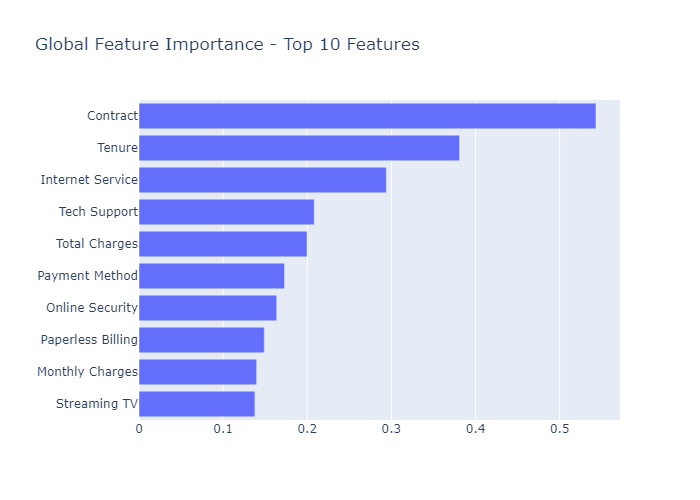

In [17]:
NUM_GLOBAL_FEATURES_TO_SHOW = 10

ebm_global = ebm_model.explain_global()

global_importance_df = pd.DataFrame(ebm_global.data()).sort_values(by=['scores'], ascending=False, ignore_index=True)

temp_df = global_importance_df[: NUM_GLOBAL_FEATURES_TO_SHOW]

fig = px.bar(temp_df, x='scores', y='names', orientation='h', 
             labels={'names':'', 'scores':''},
             title=f"Global Feature Importance - Top {NUM_GLOBAL_FEATURES_TO_SHOW} Features")

fig.update_layout(yaxis=dict(autorange="reversed"), hovermode=False)

# To display in JupyterLab
# fig.show()

# To display in GitHub and JupyterLab
display(Image(fig.to_image(format='png')))

## Local Explainability Examples

In [18]:
# Score entire dataframe

total_scored_df = pd.concat([total_df.reset_index(drop=True),
                             pd.DataFrame(ebm_model.predict_proba(total_df[features])[:, [1]],
                                          columns=['model_score']).reset_index(drop=True)],
                            axis=1)

total_scored_df.head()

,CustomerID,Churn,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,model_score
0,1,No,Female,No,Yes,No,1,No,'No phone service',DSL,...,No,No,No,No,Month-to-month,Yes,'Electronic check',29.85,29.85,0.722790
1,2,No,Male,No,No,No,34,Yes,No,DSL,...,Yes,No,No,No,'One year',No,'Mailed check',56.95,1889.50,0.043505
2,3,Yes,Male,No,No,No,2,Yes,No,DSL,...,No,No,No,No,Month-to-month,Yes,'Mailed check',53.85,108.15,0.283015
3,4,No,Male,No,No,No,45,No,'No phone service',DSL,...,Yes,Yes,No,No,'One year',No,'Bank transfer (automatic)',42.30,1840.75,0.042896
4,5,Yes,Female,No,No,No,2,Yes,No,'Fiber optic',...,No,No,No,No,Month-to-month,Yes,'Electronic check',70.70,151.65,0.692860


In [19]:
# Derive each feature's explanation score for each record

explanation_scores_df = pd.concat([total_df[['CustomerID']].reset_index(drop=True),
                                   pd.DataFrame(ebm_model.predict_and_contrib(total_df[features])[1], 
                                                columns=ebm_model.feature_names_in_)],
                                  axis=1)

explanation_scores_df = explanation_scores_df.melt(id_vars='CustomerID', value_name='explanation_score')


explanation_scores_df.sort_values('CustomerID').head(len(features)).sort_values(by='explanation_score',
                                                                                key=lambda x: abs(x),
                                                                                ascending=False).reset_index(drop=True)

,CustomerID,variable,explanation_score
0,1,Tenure,0.926458
1,1,Total Charges,0.600697
2,1,Contract,0.490797
3,1,Internet Service,-0.338561
4,1,Payment Method,0.256785
5,1,Tech Support,0.210154
6,1,Online Security,0.164157
7,1,Multiple Lines,0.130889
8,1,Phone Service,0.129441
9,1,Paperless Billing,0.125590


In [20]:
# Create a data frame with custom formats and labels for explainability

data_values_df = total_df.copy()

data_values_df.drop(columns='Churn', inplace=True)

data_values_df['Monthly Charges'] = '$' + data_values_df['Monthly Charges'].apply("{:,.2f}".format)
data_values_df['Total Charges'] = '$' + data_values_df['Total Charges'].apply("{:,.2f}".format)
data_values_df['Tenure'] = data_values_df['Tenure'].apply("{:,.0f}".format)

data_values_df = data_values_df.melt(id_vars=['CustomerID'], value_name='data_value')

data_values_df['data_value'] = data_values_df['data_value'].str.replace("'", "")

data_values_df['label'] = data_values_df['variable'].astype(str) + " = " + data_values_df['data_value'].astype(str)

data_values_df[data_values_df['CustomerID'] == 1].reset_index(drop=True)

,CustomerID,variable,data_value,label
0,1,Gender,Female,Gender = Female
1,1,Senior Citizen,No,Senior Citizen = No
2,1,Partner,Yes,Partner = Yes
3,1,Dependents,No,Dependents = No
4,1,Tenure,1,Tenure = 1
5,1,Phone Service,No,Phone Service = No
6,1,Multiple Lines,No phone service,Multiple Lines = No phone service
7,1,Internet Service,DSL,Internet Service = DSL
8,1,Online Security,No,Online Security = No
9,1,Online Backup,Yes,Online Backup = Yes


In [21]:
local_df = pd.merge(data_values_df, explanation_scores_df, on=['CustomerID', 'variable'])

local_df['abs_explanation_score'] = abs(local_df['explanation_score'])

local_df.head()

,CustomerID,variable,data_value,label,explanation_score,abs_explanation_score
0,1,Gender,Female,Gender = Female,0.048098,0.048098
1,2,Gender,Male,Gender = Male,-0.046980,0.046980
2,3,Gender,Male,Gender = Male,-0.046980,0.046980
3,4,Gender,Male,Gender = Male,-0.046980,0.046980
4,5,Gender,Female,Gender = Female,0.048098,0.048098


In [22]:
# Select records with highest and lowest scores to illustrate local explainability

max_score_customer = total_scored_df.sort_values('model_score', ascending=False).head(1)['CustomerID'].reset_index(drop=True)[0]
min_score_customer = total_scored_df.sort_values('model_score', ascending=True).head(1)['CustomerID'].reset_index(drop=True)[0]

print(max_score_customer)
print(min_score_customer)

4793
2520


In [23]:
def explain_single_prediction(customer_id, num_features=999, plot_height=450):
    truth = total_df[total_df['CustomerID'] == customer_id]['Churn'].item()
    
    temp_df = local_df[local_df['CustomerID'] == customer_id].sort_values('abs_explanation_score', ascending=False)
    
    if temp_df.shape[0] <= num_features:
        subtitle = f"All {temp_df.shape[0]:,} features"
    else:
        subtitle = f"Top {num_features} features"
        
    temp_df = temp_df.head(num_features)
    
    temp_df['influence'] = np.where(temp_df['explanation_score'] > 0, 'Towards Churn', 'Away from Churn')
    
    fig = px.bar(temp_df, x='explanation_score', y='label', color='influence',
                 color_discrete_map={'Towards Churn': 'red', 'Away from Churn': 'green'},
                 orientation='h', height=plot_height,
                 labels={'label':'', 'explanation_score': 'Explanation Score', 'influence': 'Influence'},
                 title=f"Local Explanation for CustomerID {customer_id} (actual churn = {truth})<br><sup>{subtitle}</sup>")
    
    fig.update_layout(yaxis=dict(autorange='reversed'),
                      showlegend=True,
                      hovermode=False)
    
    # To display in JupyterLab
    # fig.show()
    
    # To display in GitHub and JupyterLab
    display(Image(fig.to_image(format="png")))

### Record with Highest Score

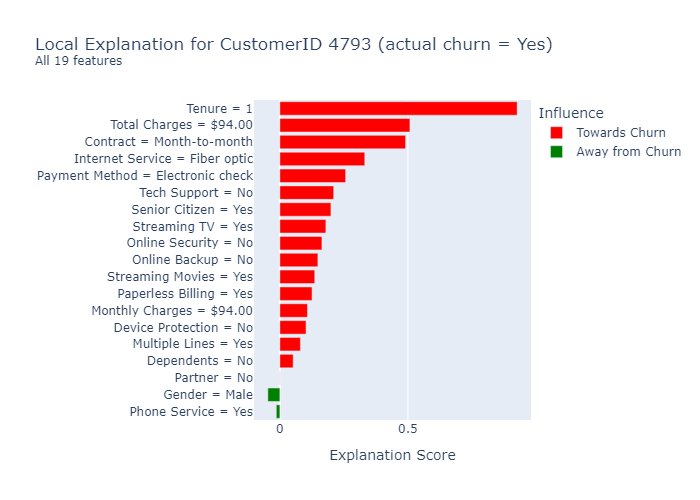

In [24]:
explain_single_prediction(customer_id=max_score_customer, plot_height=500)

### Record with Lowest Score

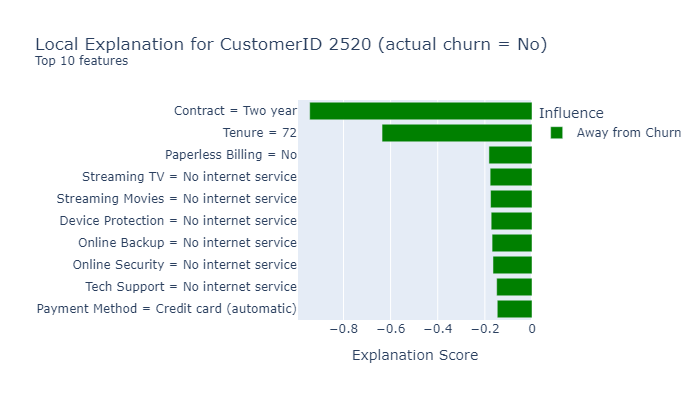

In [25]:
explain_single_prediction(customer_id=min_score_customer, num_features=10, plot_height=400)

# Appendix

## Session Info for Reproducibility

In [26]:
session_info.show()

## Custom `gains` Function

In [27]:
from pygments import highlight
from pygments.lexers import Python2Lexer
from pygments.formatters import TerminalFormatter
import inspect

print(highlight(inspect.getsource(gains), Python2Lexer(), TerminalFormatter()))

def gains(input_df, series_var, truth_var, score_var):
    """
    This function serves two purposes:
    (1) Calculate the gain capture statistic for each model/series being evaluated in the input dataframe
    (2) Generate an output dataframe with x and y coordinates to produce a cumulative gains curve for each model/series
    a
    Arguments:
    (1) input_df   --> Name of the dataframe that contains the additional three required arguments.
    (2) series_var --> Column that identifies the model/series.
    (3) truth_var  --> Column name of the target variable.  It's assumed that the only values are
                       'Yes' (the positive class) and 'No' (the negative class).
    (4) score_var  --> Column name of the model/series score.  It's assumed that scores are positively correlated with
                       the positive class.
    
    The input_df dataframe should contain one row for every model/series x record combination
    
    Returns:
    (1) gain_statistics --> G